In [1]:
# Berlin Transport Network Comparison
# Cell 1: Import libraries and functions from our script

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
import os
import sys

sys.path.append('../src')  # Adjust path if needed
# Import our comparison script functions 
# (Assuming the script is saved as network_comparison.py in the same directory)
from network_comparison import parse_stops, compare_stops, export_discrepancies_csv

# For better visualizations
plt.style.use('ggplot')
sns.set(font_scale=1.2)
%matplotlib inline

In [2]:
# Cell 2: Set parameters for the comparison

# Define the years and sides to compare
# Change these parameters to compare different snapshots
earlier_year = "1964"
later_year = "1965"
side = "east"  # Options: "east", "west", or other regional divisions

# Construct file paths from parameters
data_dir = "../data/raw"
earlier_file = f"{data_dir}/{earlier_year}_{side}.csv"
later_file = f"{data_dir}/{later_year}_{side}.csv"

# Load data
df_earlier = pd.read_csv(earlier_file)
df_later = pd.read_csv(later_file)

# Add parsed stops columns for analysis
df_earlier['parsed_stops'] = df_earlier['stops'].apply(parse_stops)
df_later['parsed_stops'] = df_later['stops'].apply(parse_stops)

# Show basic info about each dataset
print(f"Earlier snapshot ({earlier_year}_{side}): {len(df_earlier)} lines")
print(f"Later snapshot ({later_year}_{side}): {len(df_later)} lines")

Earlier snapshot (1964_east): 76 lines
Later snapshot (1965_east): 74 lines


Common lines: 71
Lines only in 1964: 3
Lines only in 1965: 3

Examples of lines only in 1964: ['A38', 'A82P', 'AD']
Examples of lines only in 1965: ['46P', 'AD/38', 'KBS 105']


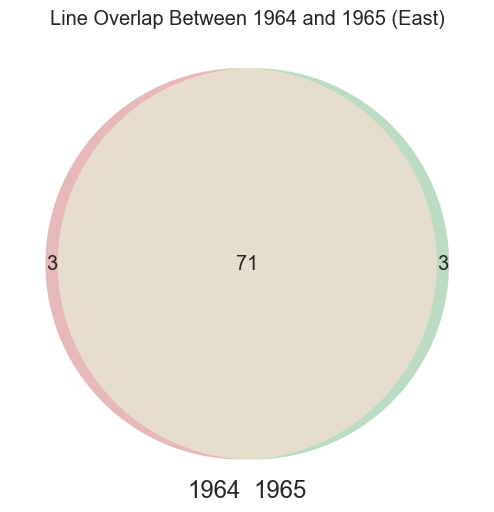

In [3]:
# Cell 3: Compare line presence between snapshots

# Identify common and unique lines
lines_earlier = set(df_earlier['line_name'])
lines_later = set(df_later['line_name'])

common_lines = lines_earlier.intersection(lines_later)
only_in_earlier = lines_earlier - lines_later
only_in_later = lines_later - lines_earlier

print(f"Common lines: {len(common_lines)}")
print(f"Lines only in {earlier_year}: {len(only_in_earlier)}")
print(f"Lines only in {later_year}: {len(only_in_later)}")

# Display some examples if there are any
if only_in_earlier:
    print(f"\nExamples of lines only in {earlier_year}: {sorted(list(only_in_earlier))[:5]}")
if only_in_later:
    print(f"Examples of lines only in {later_year}: {sorted(list(only_in_later))[:5]}")

# Create Venn diagram of line overlap
plt.figure(figsize=(10, 6))
venn = venn2([lines_earlier, lines_later], (earlier_year, later_year))
plt.title(f'Line Overlap Between {earlier_year} and {later_year} ({side.capitalize()})')
plt.show()

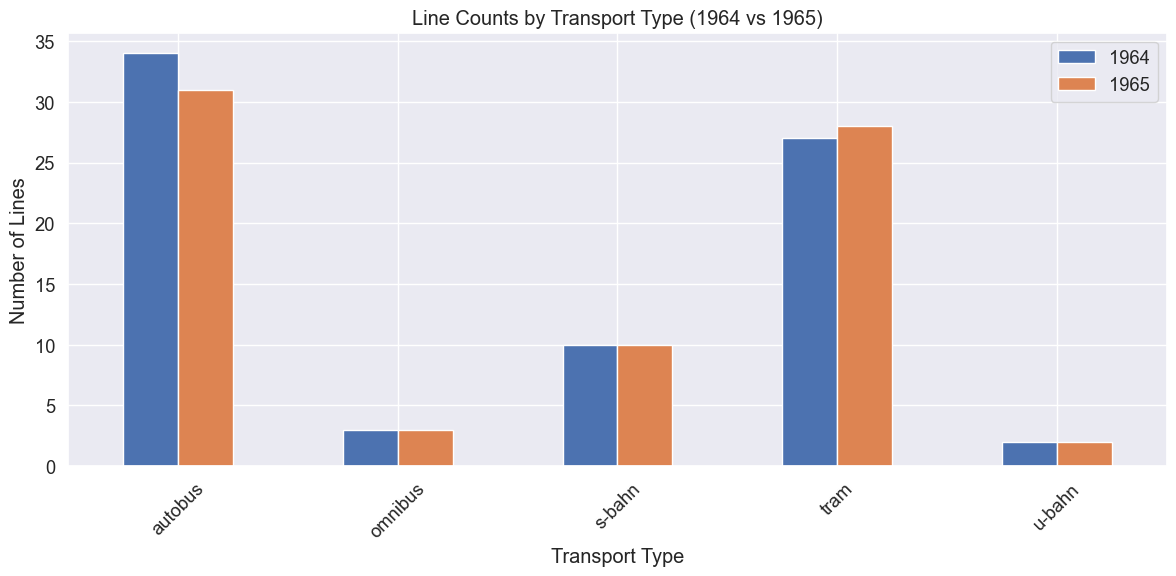

In [4]:
# Cell 4: Analyze transport type distribution

# Count lines by type for each snapshot
type_counts_earlier = df_earlier['type'].value_counts().reset_index()
type_counts_earlier.columns = ['type', earlier_year]

type_counts_later = df_later['type'].value_counts().reset_index()
type_counts_later.columns = ['type', later_year]

# Merge the two counts
combined_types = pd.merge(type_counts_earlier, type_counts_later, on='type', how='outer').fillna(0)
combined_types = combined_types.sort_values(by='type')

# Create a grouped bar chart
plt.figure(figsize=(12, 6))
combined_types.plot(x='type', y=[earlier_year, later_year], kind='bar', ax=plt.gca())
plt.title(f'Line Counts by Transport Type ({earlier_year} vs {later_year})')
plt.xlabel('Transport Type')
plt.ylabel('Number of Lines')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check if any transport types were added or removed between snapshots
transport_types_earlier = set(df_earlier['type'].unique())
transport_types_later = set(df_later['type'].unique())
new_types = transport_types_later - transport_types_earlier
removed_types = transport_types_earlier - transport_types_later

if new_types:
    print(f"Transport types added in {later_year}: {new_types}")
if removed_types:
    print(f"Transport types removed in {later_year}: {removed_types}")


In [5]:
# Cell 5: Find lines with discrepancies

# Initialize counters for different types of discrepancies
stop_differences = []
frequency_differences = []
length_differences = []

for line_name in sorted(common_lines):
    line_earlier = df_earlier[df_earlier['line_name'] == line_name].iloc[0]
    line_later = df_later[df_later['line_name'] == line_name].iloc[0]
    
    # Compare stops
    stops_comparison = compare_stops(line_earlier['parsed_stops'], line_later['parsed_stops'])
    
    # Check for differences
    if stops_comparison['added'] or stops_comparison['removed'] or stops_comparison['reordered']:
        stop_differences.append({
            'line_name': line_name,
            'type': line_earlier['type'],
            f'stops_{earlier_year}': len(line_earlier['parsed_stops']),
            f'stops_{later_year}': len(line_later['parsed_stops']),
            'added': len(stops_comparison['added']),
            'removed': len(stops_comparison['removed']),
            'reordered': stops_comparison['reordered']
        })
    
    # Check frequency differences
    if line_earlier['frequency (7:30)'] != line_later['frequency (7:30)']:
        frequency_differences.append({
            'line_name': line_name,
            'type': line_earlier['type'],
            f'frequency_{earlier_year}': line_earlier['frequency (7:30)'],
            f'frequency_{later_year}': line_later['frequency (7:30)'],
            'difference': line_later['frequency (7:30)'] - line_earlier['frequency (7:30)'] 
                if pd.notna(line_earlier['frequency (7:30)']) and pd.notna(line_later['frequency (7:30)']) 
                else None
        })
    
    # Check length differences
    if line_earlier['length (time)'] != line_later['length (time)']:
        length_differences.append({
            'line_name': line_name,
            'type': line_earlier['type'],
            f'length_{earlier_year}': line_earlier['length (time)'],
            f'length_{later_year}': line_later['length (time)'],
            'difference': line_later['length (time)'] - line_earlier['length (time)']
                if pd.notna(line_earlier['length (time)']) and pd.notna(line_later['length (time)'])
                else None
        })

# Create DataFrames for easier analysis
stop_diff_df = pd.DataFrame(stop_differences)
freq_diff_df = pd.DataFrame(frequency_differences)
length_diff_df = pd.DataFrame(length_differences)

# Display summary statistics
print(f"Lines with stop differences: {len(stop_diff_df)} ({len(stop_diff_df)/len(common_lines)*100:.1f}%)")
print(f"Lines with frequency differences: {len(freq_diff_df)} ({len(freq_diff_df)/len(common_lines)*100:.1f}%)")
print(f"Lines with length differences: {len(length_diff_df)} ({len(length_diff_df)/len(common_lines)*100:.1f}%)")

# Show examples of each type of discrepancy
if not stop_diff_df.empty:
    print(f"\nExample stop differences (showing top 3):")
    display(stop_diff_df.head(3))

if not freq_diff_df.empty:
    print(f"\nExample frequency differences (showing top 3):")
    display(freq_diff_df.head(3))

if not length_diff_df.empty:
    print(f"\nExample length differences (showing top 3):")
    display(length_diff_df.head(3))

Lines with stop differences: 59 (83.1%)
Lines with frequency differences: 20 (28.2%)
Lines with length differences: 27 (38.0%)

Example stop differences (showing top 3):


,line_name,type,stops_1964,stops_1965,added,removed,reordered
0,1,tram,8,9,4,3,False
1,11,tram,8,9,3,2,False
2,13,tram,12,12,5,5,False



Example frequency differences (showing top 3):


,line_name,type,frequency_1964,frequency_1965,difference
0,84,tram,10,20.0,10.0
1,A,u-bahn,2,5.0,3.0
2,A27,autobus,10,7.0,-3.0



Example length differences (showing top 3):


,line_name,type,length_1964,length_1965,difference
0,1,tram,28,27.0,-1.0
1,3,tram,45,43.0,-2.0
2,4,tram,26,23.0,-3.0


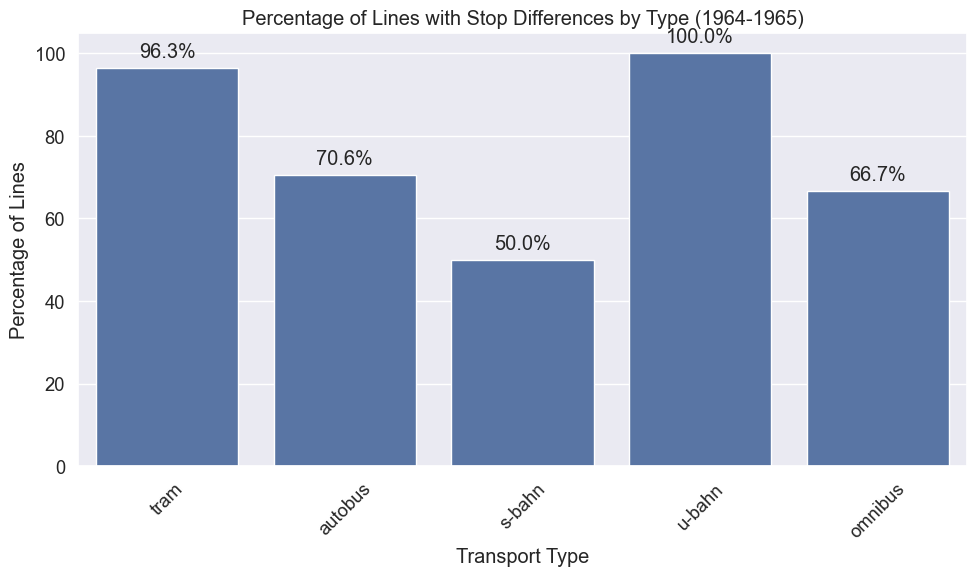

In [6]:
# Cell 6: Analyze discrepancies by transport type

# Check which transport types have the most discrepancies
if not stop_diff_df.empty:
    stop_by_type = stop_diff_df['type'].value_counts().reset_index()
    stop_by_type.columns = ['type', 'count']
    
    # Calculate percentage of lines of each type that have discrepancies
    type_counts = df_earlier['type'].value_counts().reset_index()
    type_counts.columns = ['type', 'total']
    
    stop_by_type = pd.merge(stop_by_type, type_counts, on='type', how='left')
    stop_by_type['percentage'] = stop_by_type['count'] / stop_by_type['total'] * 100
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='type', y='percentage', data=stop_by_type)
    plt.title(f'Percentage of Lines with Stop Differences by Type ({earlier_year}-{later_year})')
    plt.xlabel('Transport Type')
    plt.ylabel('Percentage of Lines')
    plt.xticks(rotation=45)
    
    # Add value labels on top of the bars
    for i, p in enumerate(ax.patches):
        ax.annotate(f"{p.get_height():.1f}%", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'bottom',
                    xytext = (0, 5), textcoords = 'offset points')
    
    plt.tight_layout()
    plt.show()

In [7]:
# Cell 7: Analyze a specific line in detail

# Function to analyze a specific line in detail
def analyze_line_detail(line_name):
    """Analyze differences between snapshots for a specific line"""
    if line_name not in common_lines:
        print(f"Line {line_name} does not exist in both datasets")
        return None, None
    
    line_earlier = df_earlier[df_earlier['line_name'] == line_name].iloc[0]
    line_later = df_later[df_later['line_name'] == line_name].iloc[0]
    
    print(f"Analysis of line {line_name} ({line_earlier['type']})")
    print("=" * 50)
    
    # Basic attributes
    print(f"Frequency (7:30): {line_earlier['frequency (7:30)']} → {line_later['frequency (7:30)']}")
    print(f"Length (time): {line_earlier['length (time)']} → {line_later['length (time)']}")
    
    # Compare stops
    stops_earlier = line_earlier['parsed_stops']
    stops_later = line_later['parsed_stops']
    
    print(f"\nTotal stops: {len(stops_earlier)} → {len(stops_later)}")
    
    # Get detailed stop comparison
    stops_comparison = compare_stops(stops_earlier, stops_later)
    
    if stops_comparison['removed']:
        print(f"\nStops removed from {earlier_year} to {later_year}:")
        for stop in stops_comparison['removed']:
            print(f"  - {stop}")
    
    if stops_comparison['added']:
        print(f"\nStops added in {later_year}:")
        for stop in stops_comparison['added']:
            print(f"  - {stop}")
    
    if stops_comparison['reordered']:
        print(f"\nNote: The stops have been reordered between {earlier_year} and {later_year}")
    
    return stops_earlier, stops_later

# Find a line with interesting changes for analysis
# First, try to find a line with both stop and frequency changes
def find_interesting_line():
    # First check if any lines have both stop and frequency differences
    if not stop_diff_df.empty and not freq_diff_df.empty:
        both_changes = set(stop_diff_df['line_name']).intersection(set(freq_diff_df['line_name']))
        if both_changes:
            return list(both_changes)[0]
    
    # Otherwise return a line with stop changes
    if not stop_diff_df.empty:
        return stop_diff_df.iloc[0]['line_name']
    
    # Otherwise return a line with frequency changes
    if not freq_diff_df.empty:
        return freq_diff_df.iloc[0]['line_name']
    
    # If no changes at all, return a random common line
    return list(common_lines)[0] if common_lines else None

# Find an interesting line to analyze
line_to_analyze = find_interesting_line()
if line_to_analyze:
    print(f"Selected line {line_to_analyze} for detailed analysis\n")
    stops_earlier, stops_later = analyze_line_detail(line_to_analyze)
else:
    print("No lines available for analysis")

Selected line AL for detailed analysis

Analysis of line AL (autobus)
Frequency (7:30): 32 → 36.0
Length (time): 15 → 15.0

Total stops: 3 → 5

Stops removed from 1964 to 1965:
  - Lindenberg

Stops added in 1965:
  - Lindenberg, Dorf
  - Lindenberg, Mühle
  - Lindenberg, Schule


In [8]:
# Cell 8: Visualize station differences for a specific line

def visualize_stops_diff(stops_earlier, stops_later, title="Stop Comparison"):
    """Create a visual comparison of stops between two snapshots"""
    # Create a DataFrame for visualization
    stop_df = pd.DataFrame({
        earlier_year: pd.Series(stops_earlier),
        later_year: pd.Series(stops_later)
    })
    
    # Fill with empty strings for cleaner visualization
    stop_df = stop_df.fillna('')
    
    # Create color maps for highlighting differences
    def highlight_diff(s):
        is_earlier = s.name == earlier_year
        is_later = s.name == later_year
        
        # Create a style Series
        styles = pd.Series([''] * len(s), index=s.index)
        
        for i, val in enumerate(s):
            if val == '':
                # Red for missing in later, green for added in later
                styles[i] = 'background-color: #ffcccc' if is_earlier else 'background-color: #ccffcc'
            elif (is_earlier and val not in stops_later) or (is_later and val not in stops_earlier):
                # Yellow for changed stations
                styles[i] = 'background-color: #ffffcc'
        
        return styles
    
    # Display styled DataFrame
    display(stop_df.style.apply(highlight_diff, axis=0)
             .set_caption(title)
             .set_properties(**{'text-align': 'left'})
             .set_table_styles([
                 {'selector': 'caption', 'props': [('font-weight', 'bold'), ('font-size', '16px')]},
                 {'selector': 'th', 'props': [('font-weight', 'bold'), ('background-color', '#eaeaea')]}
             ]))

# Visualize stops for the line we analyzed
if stops_earlier is not None and stops_later is not None:
    visualize_stops_diff(
        stops_earlier, 
        stops_later, 
        f"Stop Comparison for Line {line_to_analyze} ({earlier_year} vs {later_year})"
    )
    
    # Add legend for the color coding
    print("\nColor Legend:")
    print("  • Yellow: Stops that differ between snapshots")
    print(f"  • Red: Stops removed in {later_year}")
    print(f"  • Green: Stops added in {later_year}")

,1964,1965
0,Neu-Lindenberg,Neu-Lindenberg
1,Lindenberg,"Lindenberg, Schule"
2,"Malchow, Dorfstr.","Lindenberg, Dorf"
3,,"Lindenberg, Mühle"
4,,"Malchow, Dorfstr."



Color Legend:
  • Yellow: Stops that differ between snapshots
  • Red: Stops removed in 1965
  • Green: Stops added in 1965


Total lines with discrepancies: 65 (91.5%)

Lines with multiple types of discrepancies:


,line_name,type,has_stop_differences,has_frequency_differences,has_length_differences,total_discrepancy_types,stops_added,stops_removed,stops_reordered,frequency_1964,frequency_1965,length_1964,length_1965
55,KBS 103,s-bahn,True,True,True,3,17,2,False,0,NaN,0,NaN
33,A43,autobus,True,True,True,3,1,2,False,20,10.0,23,25.0
56,KBS 103a,s-bahn,True,True,True,3,3,1,False,0,NaN,0,NaN
39,A55,autobus,True,True,True,3,7,9,False,16,15.0,39,37.0
60,KBS 106a,s-bahn,True,True,True,3,3,0,False,0,NaN,0,NaN
57,KBS 104,s-bahn,True,True,True,3,0,3,False,0,NaN,0,NaN
52,KBS 101,s-bahn,True,True,True,3,1,1,False,0,NaN,0,NaN
0,1,tram,True,False,True,2,4,3,False,20,20.0,28,27.0
4,3,tram,True,False,True,2,3,3,False,12,12.0,45,43.0
5,4,tram,True,False,True,2,7,7,False,12,12.0,26,23.0


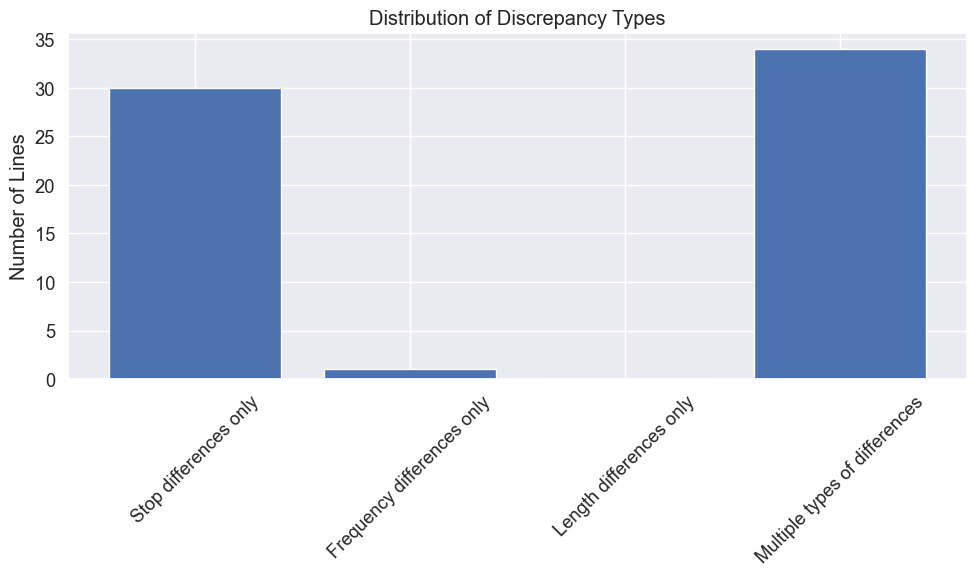

In [9]:
# Cell 9: Export discrepancies for further analysis

# Create a comprehensive DataFrame with all discrepancies
all_discrepancies = pd.DataFrame()

for line_name in sorted(common_lines):
    line_earlier = df_earlier[df_earlier['line_name'] == line_name].iloc[0]
    line_later = df_later[df_later['line_name'] == line_name].iloc[0]
    
    # Compare stops
    stops_comparison = compare_stops(line_earlier['parsed_stops'], line_later['parsed_stops'])
    
    # Check for any differences
    stop_diff = bool(stops_comparison['added'] or stops_comparison['removed'] or stops_comparison['reordered'])
    freq_diff = line_earlier['frequency (7:30)'] != line_later['frequency (7:30)']
    time_diff = line_earlier['length (time)'] != line_later['length (time)']
    
    # Only include lines with discrepancies
    if stop_diff or freq_diff or time_diff:
        discrepancy = {
            'line_name': line_name,
            'type': line_earlier['type'],
            'has_stop_differences': stop_diff,
            'has_frequency_differences': freq_diff,
            'has_length_differences': time_diff,
            'total_discrepancy_types': sum([stop_diff, freq_diff, time_diff]),
            'stops_added': len(stops_comparison['added']),
            'stops_removed': len(stops_comparison['removed']),
            'stops_reordered': stops_comparison['reordered'],
            f'frequency_{earlier_year}': line_earlier['frequency (7:30)'],
            f'frequency_{later_year}': line_later['frequency (7:30)'],
            f'length_{earlier_year}': line_earlier['length (time)'],
            f'length_{later_year}': line_later['length (time)']
        }
        all_discrepancies = pd.concat([all_discrepancies, pd.DataFrame([discrepancy])], ignore_index=True)

# Display summary
print(f"Total lines with discrepancies: {len(all_discrepancies)} ({len(all_discrepancies)/len(common_lines)*100:.1f}%)")

# Create a filename based on the comparison parameters
csv_filename = f'berlin_transport_discrepancies_{earlier_year}_{later_year}_{side}.csv'

# Export discrepancies to CSV (uncomment if you want to save the file)
# all_discrepancies.to_csv(csv_filename, index=False)
# print(f"Discrepancies exported to {csv_filename}")

# Display top discrepancies (those with multiple issues)
print("\nLines with multiple types of discrepancies:")
multi_issues = all_discrepancies[all_discrepancies['total_discrepancy_types'] > 1].sort_values(
    by='total_discrepancy_types', ascending=False
)
display(multi_issues.head(10))

# Count discrepancy types
discrepancy_counts = {
    'Stop differences only': len(all_discrepancies[(all_discrepancies['has_stop_differences']) & 
                                                 (~all_discrepancies['has_frequency_differences']) & 
                                                 (~all_discrepancies['has_length_differences'])]),
    'Frequency differences only': len(all_discrepancies[(~all_discrepancies['has_stop_differences']) & 
                                                      (all_discrepancies['has_frequency_differences']) & 
                                                      (~all_discrepancies['has_length_differences'])]),
    'Length differences only': len(all_discrepancies[(~all_discrepancies['has_stop_differences']) & 
                                                   (~all_discrepancies['has_frequency_differences']) & 
                                                   (all_discrepancies['has_length_differences'])]),
    'Multiple types of differences': len(all_discrepancies[all_discrepancies['total_discrepancy_types'] > 1])
}

# Plot discrepancy types distribution
plt.figure(figsize=(10, 6))
plt.bar(discrepancy_counts.keys(), discrepancy_counts.values())
plt.title('Distribution of Discrepancy Types')
plt.ylabel('Number of Lines')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
# Cell 11: Generate recommendations for data harmonization

# Find systematic patterns that might need attention
def generate_recommendations():
    """Generate recommendations based on the discrepancy analysis"""
    recommendations = []
    
    # Check frequency patterns
    if not freq_diff_df.empty:
        # Are there consistent frequency changes by transport type?
        freq_col_diff = f'frequency_{later_year}'
        freq_col_earlier = f'frequency_{earlier_year}'
        
        # Calculate mean difference per type safely handling non-numeric values
        freq_by_type = freq_diff_df.groupby('type').apply(
            lambda x: (
                pd.to_numeric(x[freq_col_diff], errors='coerce') - 
                pd.to_numeric(x[freq_col_earlier], errors='coerce')
            ).mean()
        ).reset_index()
        freq_by_type.columns = ['type', 'difference']
        
        for _, row in freq_by_type.iterrows():
            if pd.notna(row['difference']) and abs(row['difference']) > 0:
                direction = "increased" if row['difference'] > 0 else "decreased"
                recommendations.append(
                    f"- {row['type']} lines generally show {direction} frequency between {earlier_year}-{later_year}"
                )
    
    # Check stop patterns
    if not stop_diff_df.empty:
        # Which transport types have the most stop changes?
        stop_pct_by_type = stop_diff_df.groupby('type').size() / df_earlier['type'].value_counts() * 100
        stop_pct_by_type = stop_pct_by_type.reset_index()
        stop_pct_by_type.columns = ['type', 'percentage']
        
        for _, row in stop_pct_by_type.iterrows():
            if row['percentage'] > 50:  # If more than half of lines of this type have stop changes
                recommendations.append(
                    f"- High priority: Review {row['type']} lines as {row['percentage']:.1f}% show stop changes"
                )
    
    # Overall data quality suggestions
    total_discrepancy_pct = len(all_discrepancies) / len(common_lines) * 100
    if total_discrepancy_pct > 70:
        recommendations.append(
            f"- Consider thorough methodological review as {total_discrepancy_pct:.1f}% of lines show discrepancies"
        )
    elif total_discrepancy_pct > 30:
        recommendations.append(
            f"- Establish consistent rules for handling common discrepancies ({total_discrepancy_pct:.1f}% of lines affected)"
        )
    
    # Look for specific lines with extreme changes
    if not stop_diff_df.empty:
        extreme_stop_changes = stop_diff_df[
            (stop_diff_df['added'] > 5) | 
            (stop_diff_df['removed'] > 5)
        ]
        if not extreme_stop_changes.empty:
            recommendations.append(
                f"- Review lines with extreme stop changes: {', '.join(extreme_stop_changes['line_name'].head(5))}"
            )
    
    return recommendations

recommendations = generate_recommendations()
print(f"Recommendations for Data Harmonization ({earlier_year} to {later_year}):")
print("\n".join(recommendations if recommendations else ["No specific patterns detected that require systematic handling"]))



Recommendations for Data Harmonization (1964 to 1965):
- autobus lines generally show decreased frequency between 1964-1965
- omnibus lines generally show decreased frequency between 1964-1965
- tram lines generally show increased frequency between 1964-1965
- u-bahn lines generally show increased frequency between 1964-1965
- High priority: Review autobus lines as 70.6% show stop changes
- High priority: Review omnibus lines as 66.7% show stop changes
- High priority: Review tram lines as 96.3% show stop changes
- High priority: Review u-bahn lines as 100.0% show stop changes
- Consider thorough methodological review as 91.5% of lines show discrepancies
- Review lines with extreme stop changes: 4, 71, A55, KBS 103, O37


C:\Users\noahb\AppData\Local\Temp\ipykernel_5052\1681505773.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  freq_by_type = freq_diff_df.groupby('type').apply(


In [11]:
# Cell 12: Helper functions for future comparisons

def export_discrepancies_to_csv(filename=None):
    """Export the discrepancies to a CSV file"""
    if filename is None:
        filename = f'berlin_transport_discrepancies_{earlier_year}_{later_year}_{side}.csv'
    
    if all_discrepancies.empty:
        print("No discrepancies to export")
        return
    
    all_discrepancies.to_csv(filename, index=False)
    print(f"Discrepancies exported to {filename}")

def find_highest_priority_lines(n=10):
    """Find the n lines with the most significant discrepancies"""
    if all_discrepancies.empty:
        print("No discrepancies to analyze")
        return None
    
    # Create a priority score based on different types of discrepancies
    all_discrepancies['priority_score'] = (
        all_discrepancies['total_discrepancy_types'] * 3 +
        all_discrepancies['stops_added'] + 
        all_discrepancies['stops_removed'] +
        all_discrepancies['stops_reordered'].astype(int) * 2
    )
    
    # Return the top n lines by priority score
    return all_discrepancies.sort_values(by='priority_score', ascending=False).head(n)


# Find highest priority lines to review
print("\nHighest priority lines to review for harmonization:")
priority_lines = find_highest_priority_lines(5)
if priority_lines is not None:
    display(priority_lines[['line_name', 'type', 'total_discrepancy_types', 
                           'stops_added', 'stops_removed', 'priority_score']])


Highest priority lines to review for harmonization:


,line_name,type,total_discrepancy_types,stops_added,stops_removed,priority_score
55,KBS 103,s-bahn,3,17,2,28
39,A55,autobus,3,7,9,25
63,"S-Bhf. Friedrichshagen <> Rüdersdorf, Karl-Mar...",tram,2,14,1,21
5,4,tram,2,7,7,20
13,71,tram,2,6,6,18


In [12]:
export_discrepancies_to_csv()

Discrepancies exported to berlin_transport_discrepancies_1964_1965_east.csv
